# Tequila tutorial: raw state preparation algorithm

This tutorial shows:
- How to define a quantum gate not included in Tequila's gate set
- How to construct a parametrized quantum circuit
- How to compute the fidelity between two states
- How to train a parametrized quantum circuit

In [46]:
# Import everthing you need
import tequila as tq
import numpy as np
import random
import time

## Quantum gate construction

Sometimes, one may need to use a particular quantum gate that is not included in the basic gate set. If we know the decomposition of this gate in terms of Tequila's gates, we can define a function that runs a small quantum circuit that constructs this particular gate.  
  
As an example, let's define the general one-qubit unitary gate  
$$ U(\theta,\phi,\lambda) = \left( \begin{array}{cc}
 e^{-\frac{1}{2} i (\lambda +\phi )} \cos \left(\frac{\theta }{2}\right) & -e^{\frac{1}{2} i (\lambda -\phi )} \sin \left(\frac{\theta }{2}\right) \\
 e^{-\frac{1}{2} i (\lambda -\phi )} \sin \left(\frac{\theta }{2}\right) & e^{\frac{1}{2} i (\lambda +\phi )} \cos \left(\frac{\theta }{2}\right) \end{array} \right) = R_{z}\left(\phi\right) R_{y}\left(\theta\right) R_{z}\left(\lambda\right) $$

In [47]:
# q0 = target qubit
def U(th,phi,lam,q0):
    ugate = tq.gates.Rz(target=q0,angle=phi) + tq.gates.Ry(target=q0,angle=th) + tq.gates.Rz(target=q0,angle=lam)
    return ugate
# draw the circuit for some (th,phi,lam) for qubit "0"
tq.draw(U(np.pi, np.pi/4.0, np.pi/2.0, 0))

0: ───Rz(0.25π)───Ry(π)───Rz(0.5π)───


Similarly, we can construct a multi-qubit gate. For instance, the controlled-phase gate:  
$$ CPh\left(\varphi \right) = \left(
\begin{array}{cccc}
 1 & 0 & 0 & 0 \\
 0 & 1 & 0 & 0 \\
 0 & 0 & 1 & 0 \\
 0 & 0 & 0 & e^{i \varphi } \\
\end{array}
\right)  = e^{i\phi/4} \left(R_{z}\left(\varphi/2\right)\otimes\mathbb{I}\right)CR_{z}\left(\phi/2\right)$$

In [48]:
# q0 = control qubit
# q1 = target qubit
def CPh(phi,q0,q1):
    cph = tq.gates.Rz(target=q0, angle=phi/2) + tq.gates.CRz(control=q0, target=q1, angle=phi/2)
    return cph
# draw the circuit for some varphi for qubits "0" and "1"
tq.draw(CPh(np.pi/2,0,1))

0: ───Rz(0.25π)───@───────────
                  │
1: ───────────────Rz(0.25π)───


The gate defined is equal to $CPh(\varphi)$ gate up to a global phase.

## Compute the fidelity

Let's compute the fidelity between two states, one constructed from a string (target state $|\tilde{\psi}\rangle$) and other obtained from a given quantum circuit, $|\psi\rangle$.

In [49]:
# Target state example: Bell state
wfn_targ = tq.QubitWaveFunction.from_string(string="1.0*|00> + 1.0*|11>")
wfn_targ = wfn_targ.normalize() # Remember to normalize the state!!! 
print("target state: ", wfn_targ) # Print the wavefunction

target state:  +0.7071|00> +0.7071|11> 


In [50]:
# Quantum circuit
q0 = 0
q1 = 1
qc = U(0.2, np.pi/2.0, 0.5, q0) + tq.gates.CNOT(target=q1,control=q0) + CPh(0.4,q0,q1) + tq.gates.Ry(target=q1,angle=0.5)
wfn_qc = tq.simulate(qc) # Simulate the wavefunction 
print("circuit state: ", wfn_qc) 
print("circuit diagram: ")
tq.draw(qc)

circuit state:  +0.9641e^(-0.3614πi)|00> +0.0247e^(+0.8932πi)|10> +0.2462e^(-0.3614πi)|01> +0.0967e^(-0.1068πi)|11> 
circuit diagram: 
0: ───Rz(0.5π)───Ry(0.064π)───Rz(0.159π)───@───Rz(0.064π)───@─────────────────────────
                                           │                │
1: ────────────────────────────────────────X────────────────Rz(0.064π)───Ry(0.159π)───


There are two ways to compute the fidelity of these two states. The natural way to do it, in case we have both wavefunctions, is just by computing the inner product of these two states:
$$ F\left(|\psi\rangle, |\tilde{\psi}\rangle\right) = |\langle \psi | \tilde{\psi} \rangle|^2 $$

In [51]:
fidelity = abs(wfn_targ.inner(wfn_qc))**2
print('fidelity = ', fidelity)

fidelity =  0.5343666886804502


The second method consists on computing the expected value of the target state density matrix operator $\rho = |\tilde{\psi}\rangle\langle\tilde{\psi}|$, i.e. 
$$ F\left(|\psi\rangle, |\tilde{\psi}\rangle\right) = \langle \psi | \rho |\psi\rangle = \langle \psi |\tilde{\psi}\rangle \langle \tilde{\psi} |\psi\rangle = |\langle \psi | \tilde{\psi} \rangle|^2$$

To do so, we need to write the density operator in terms of pauli matrices:

In [52]:
# construct the density operator of target state
rho_targ =  tq.paulis.Projector(wfn=wfn_targ)
print(rho_targ)

+0.2500+0.2500Z(0)Z(1)+0.2500X(0)X(1)-0.2500Y(0)Y(1)


Then, we trait this operator as a Hamiltonian and compute the objective expectation value:

In [53]:
O = tq.Objective.ExpectationValue(U=qc, H=rho_targ)
fidelity= tq.simulate(O)
print('fidelity = ', fidelity)

fidelity =  0.5343666672706604


## Construct a parametrized quantum circuit 

Parametrized quantum circuits (PQC) are usually defined with a small gate set. Same gates are used along the circuit with different parameters, which makes more natural to define them as vectors. In the following example, we construct a parametrized quantum circuit of two qubits using the $U(\theta,\phi,\lambda)$ (defined above) and a CNOT gate. Parameters are identified with the vectors $\vec{\theta}$, $\vec{\phi}$ and $\vec{\lambda}$. The circuit ansatz consist on applying general unitary gates on both qubits, then entangle them with the CNOT gate, and finally apply another unitary gate.

In [54]:
#qubits
q0=0
q1=1

#define variables
th = [tq.Variable(name='theta_{}'.format(i)) for i in range(0,4)]
phi = [tq.Variable(name='phi_{}'.format(i)) for i in range(0,4)]
lam = [tq.Variable(name='lam_{}'.format(i)) for i in range(0,4)]

# PQC
pqc  = U(th[0],phi[0],lam[0],q0) + U(th[1],phi[1],lam[1],q1) 
pqc += tq.gates.CNOT(control = q0, target = q1)
pqc += U(th[2],phi[2],lam[2],q0) + U(th[3],phi[3],lam[3],q1)

In [55]:
# Draw the circuit for some random values
n_th = len(th)
n_phi = len(phi)
n_lam = len(lam)

th0 =[random.uniform(0, np.pi) for x in range(0,n_th)]
phi0 = [random.uniform(0, np.pi) for x in range(0,n_phi)]
lam0 = [random.uniform(0, np.pi) for x in range(0,n_lam)]

tq.draw(pqc)

0: ───Rz(-1.1349999999999998π)───Ry(0.0π)─────Rz(-1.7719999999999998π)───@───Rz(0.318π)───Ry(-1.4540000000000002π)───Rz(-0.4990000000000001π)───
                                                                         │
1: ───Rz(0.637π)─────────────────Ry(1.273π)───Rz(1.592π)─────────────────X───Rz(0.955π)───Ry(-0.8170000000000002π)───Rz(1.91π)──────────────────


We can now compute the fidelity of the output state of this PQC with some two-qubit random state:

In [56]:
# 2-qubit random state wavefunction from array
rand_array = np.asarray([random.uniform(-1, 1)+1j*random.uniform(-1, 1) for x in range(1,5)])
wfn_rand = tq.QubitWaveFunction.from_array(rand_array)
wfn_rand = wfn_rand.normalize()
print("random state: ", wfn_rand)

random state:  +0.6455e^(+0.2551πi)|00> +0.5313e^(-0.3078πi)|01> +0.4405e^(+0.7781πi)|10> +0.3270e^(-0.2695πi)|11> 


And now we can compute the fidelity of these two states:

In [57]:
# First, create the dictionary with the values of the parameters (we take the random values generated above)
dic_var = dict(zip([str(th[i]) for i in range(0,n_th)],th0))
dic_var = {**dic_var, **dict(zip([str(phi[i]) for i in range(0,n_phi)],phi0))}
dic_var = {**dic_var, **dict(zip([str(lam[i]) for i in range(0,n_lam)],lam0))}

# Fidelity method 1: using inner product
wfn_pqc = tq.simulate(pqc, variables=dic_var) # compute the PQC wavefunction
fid_rand = abs(wfn_rand.inner(wfn_pqc))**2
print("fidelity = ", fid_rand)

# Fidelity method 2: using the the density matrix as objective
rho_rand = tq.paulis.Projector(wfn=wfn_rand) # density operator target state
fid_pqc = tq.Objective.ExpectationValue(U=pqc, H=rho_rand)
print("fidelity = ", tq.simulate(fid_pqc, variables = dic_var))

fidelity =  0.22507326895901397
fidelity =  0.2250732183456421


## State preparation algorithm

This algorithm minimizes the fidelity between a PQC and a the target state. Since the optimizer only minimizes, we will minimize the infidelity, i.e. $ 1 - F(|\tilde{\psi}\rangle,|\psi\rangle)$.

We can use any of the two methods to compute the infidelity, but it will be more convenient to use the second one.

The goal of this example is to obtain a quantum circuit that generates the Bell state
$$ |\tilde{\psi}\rangle = \frac{1}{\sqrt{2}}\left(|00\rangle + |11\rangle\right) $$

In [58]:
# Bell state wavefunction from array
bell_array = np.asarray([1,0,0,1])
wfn_bell = tq.QubitWaveFunction.from_array(bell_array)
wfn_bell = wfn_targ.normalize()
print("Bell state: ", wfn_bell)

Bell state:  +0.7071|00> +0.7071|11> 


Infidelity =  0.00012683868408203125
Fidelity =  0.999873161315918
Execution time:  15.652284145355225  sec


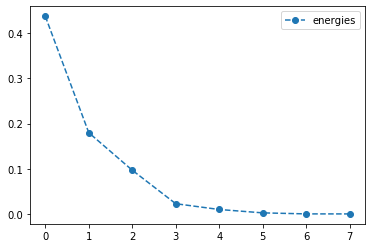

None


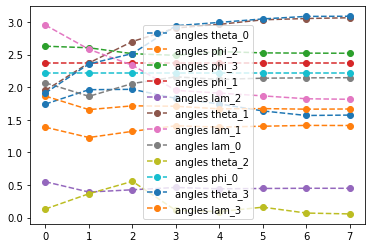

None


In [59]:
rho_bell = tq.paulis.Projector(wfn=wfn_bell) # density operator

# we take as initial values ther random values generated above
initial_values = dic_var
# Infidelity = 1 - Fidelity
inf =  1.0 - tq.Objective.ExpectationValue(U=pqc, H=rho_bell)

# we can define the bounds on the parameters
# Caution! Not all minimizers accept bounds! In this example, we use 'TNC' minimizer.
# bounds should be defined in a dictionary form, as initial_values
max_angles = 2*np.pi
min_angles = 0
bnds_list = [[min_angles,max_angles]]
for i in range(0, len(dic_var)):
    bnds_list.append([min_angles,max_angles])
bnds = dict(zip([str(th[i]) for i in range(0,n_th)],bnds_list))
bnds = {**bnds, **dict(zip([str(phi[i]) for i in range(0,n_phi)],bnds_list))}
bnds = {**bnds, **dict(zip([str(lam[i]) for i in range(0,n_lam)],bnds_list))}

# set "silent = True" to avoid printing all the minimization process
t0 = time.time()
infid = tq.optimizer_scipy.minimize(objective=inf, initial_values=initial_values, method = 'TNC', method_bounds = bnds, silent=True)
t1 = time.time()

print("Infidelity = ", infid.energy)
print("Fidelity = ", 1.0-infid.energy)
print("Execution time: ", t1-t0, " sec" )

print(infid.history.plot())
print(infid.history.plot('angles'))

We can check that the final state solution is the Bell state up to a global phase:

In [60]:
wfn_sol = tq.simulate(pqc, variables=infid.angles)
print('final state solution: ')
print(wfn_sol)

final state solution: 
+0.7067e^(+0.0573πi)|00> +0.0071e^(+0.5729πi)|10> +0.0078e^(-0.1512πi)|01> +0.7074e^(+0.0599πi)|11> 


To obtain the angles of the PQC:

In [61]:
infid.angles

{theta_0: 1.570929890592816,
 phi_2: 1.6641885582517042,
 phi_3: 2.5194912592397096,
 phi_1: 2.3694379705575095,
 lam_2: 0.4478370208115292,
 theta_1: 3.063598765794688,
 lam_1: 1.8133549674141436,
 lam_0: 2.144099517443789,
 theta_2: 0.05513092326205582,
 phi_0: 2.2167258755276262,
 theta_3: 3.0868323570139853,
 lam_3: 1.4109851098288564}